<a href="https://colab.research.google.com/github/wicky818/UTKFace_Deep_Learning/blob/main/UTKFace_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install tensorflow-gpu

     |████████████████████████████████| 1.8 MB 5.8 MB/s 
     |████████████████████████████████| 181 kB 39.0 MB/s 
     |████████████████████████████████| 145 kB 41.7 MB/s 
     |████████████████████████████████| 63 kB 870 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 438 kB 58.0 MB/s 
     |████████████████████████████████| 1.6 MB 51.2 MB/s 
     |████████████████████████████████| 5.8 MB 52.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installati

# Getting Data

In [2]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning.git

Cloning into 'UTKFace_Deep_Learning'...
remote: Enumerating objects: 23332, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 23332 (delta 0), reused 9 (delta 0), pack-reused 23323
Receiving objects: 100% (23332/23332), 110.30 MiB | 30.99 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (33489/33489), done.


In [3]:
!ls

sample_data  UTKFace_Deep_Learning


In [4]:
import os

os.chdir("/content/UTKFace_Deep_Learning")
images = os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')
print('Total number of images: ', len(images))

Total number of images:  23708


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Loading Data

[age] is an integer from 0 to 116, indicating the age\
[gender] is either 0 (male) or 1 (female)\
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).\
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [6]:
images = []
ages = []
genders = []
race = []

for i in os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace'):
    split = i.split('_')
    ages.append((split[0]))
    genders.append((split[1]))
    race.append((split[2]))

    images.append(Image.open('/content/UTKFace_Deep_Learning/dataset/UTKFace/' + i))

In [7]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
race = pd.Series(list(race), name = 'Races')

df = pd.concat([images, ages, genders, race], axis=1)

In [8]:
df["Races"].unique()

array(['1', '2', '0', '3', '4', '20170109150557335.jpg.chip.jpg',
       '20170116174525125.jpg.chip.jpg', '20170109142408075.jpg.chip.jpg'],
      dtype=object)

In [9]:
# Cleanup bad data points without "Races"

df.drop(df[df["Races"] == "20170116174525125.jpg.chip.jpg"].index, inplace = True)
df.drop(df[df["Races"] == '20170109142408075.jpg.chip.jpg'].index, inplace = True)
df.drop(df[df["Races"] == '20170109150557335.jpg.chip.jpg'].index, inplace = True)

In [10]:
df['Ages'] = df['Ages'].astype(int)
df['Genders'] = df['Genders'].astype(int)
df['Races'] = df['Races'].astype(int)

In [11]:
df["Races"].unique()

array([1, 2, 0, 3, 4])

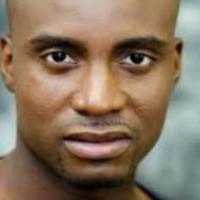

32 0 1


In [12]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0], df['Races'][0])

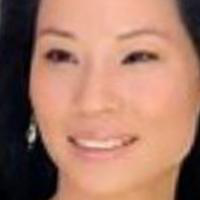

32 1 2


In [13]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1], df['Races'][1])

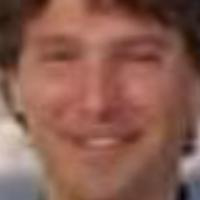

34 0 0


In [14]:
display(df['Images'][2])
print(df['Ages'][2], df['Genders'][2], df['Races'][2])

# Exploratory Data Analysis

In [15]:
df.head()

,Images,Ages,Genders,Races
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,32,0,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,32,1,2
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,34,0,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,5,1,2
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18,1,0


In [16]:
df.Races.unique()

array([1, 2, 0, 3, 4])

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


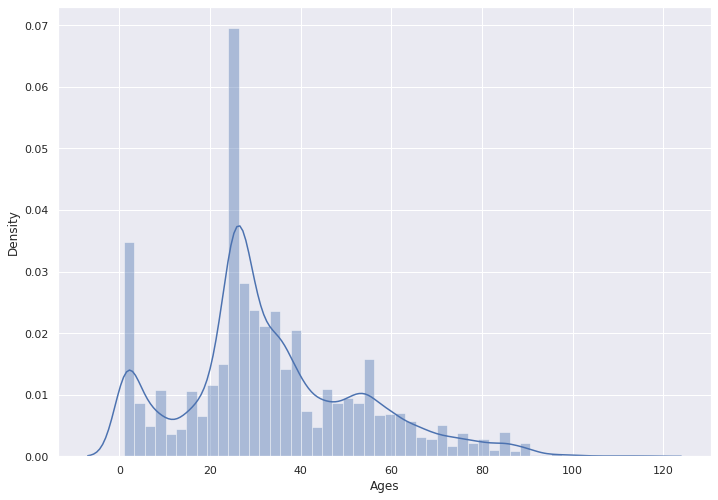

In [18]:
sns.distplot(df["Ages"])

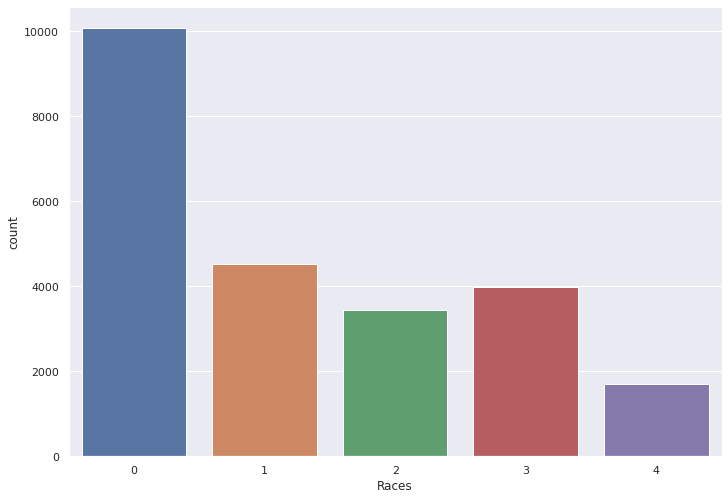

In [19]:
sns.countplot(x = "Races", data = df)

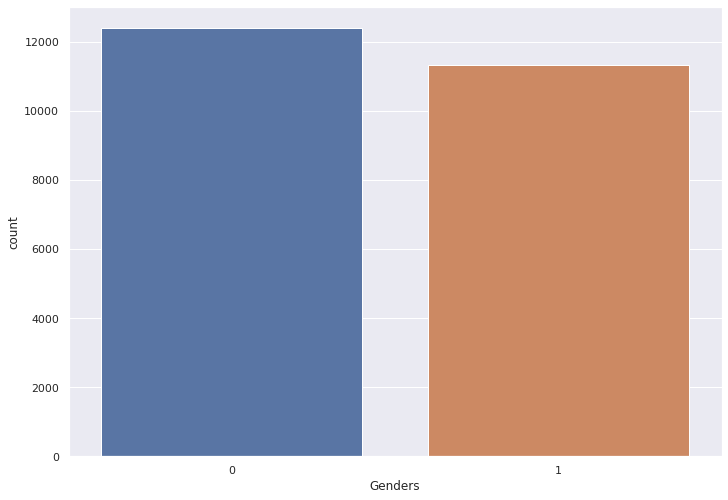

In [20]:
sns.countplot(x = "Genders", data = df)

# Age Prediction

In [21]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i]), int(df['Races'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
x.shape

(23705, 200, 200, 3)

In [23]:
type(df['Ages'][0])

numpy.int64

In [26]:
y_age = df['Ages']
y_gender = df['Genders']
y_race = df['Races']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, random_state=85)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, random_state=85)
x_train_race, x_test_race, y_train_race, y_test_race = train_test_split(x, y_race, test_size=0.2, random_state=85)